# Amazon Fine Food Reviews

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review

Text - text of the review

Objective:

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

### Loading the data
The dataset is available in two forms

.csv file

SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm 
import os

In [2]:
import zipfile
dataset_path = "Reviews.sqlite.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [3]:
# using sqlite3 read data
con = sqlite3.connect("database.sqlite")

# filtering data(only positve and negative reviews)
filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score != 3
""",con)

# score >3 --> Positive and score <3 --> Negative
def partition(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'
    
positiveNegative = filtered_data['Score']
actualScore = positiveNegative.map(partition)
filtered_data['Score'] = actualScore

In [4]:
filtered_data.shape

(525814, 10)

In [5]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
filtered_data['Score'].value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

## EDA 

Cleaning Data

At first removing duplicate values

In [7]:
display = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score != 3 AND UserId = "AR5J8UI46CURR"
ORDER BY ProductId
""",con)

In [8]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


#### Observations:
Here we can see that the ProfileName, HelpfulnessDenominator, HelpfulnessNumerator, Score, Time, Summary and Text are same.

After analysis we found that the product is same and only the flavour is different

So we will remove duplicates and keep only first value

Steps: Sort the data according to ProductId, keep first value and remove rest

In [9]:
sorted_data = filtered_data.sort_values("ProductId",ascending=True,inplace=False,kind='quicksort',na_position='last')

In [10]:
# now data is sorted, remove duplicate values
final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, keep = 'first', inplace = False)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [11]:
# checking % of data left
(final['Id'].size*1.0/filtered_data['Id'].size*1.0)*100

69.25890143662969

In [12]:
# we also have 2 rows where HelpfulnessNumerator > HelpfulnessDenominator
# But HelpnessNumerator should be always <= HelpfulnessDenominator
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score!=3 AND Id=44737 OR Id=64422
""",con)

In [13]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [14]:
filtered_data.shape

(525814, 10)

In [15]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.shape

(364171, 10)

## Text Preprocessing

In order to clean our text we will do following steps:

1:- Remove html tags from text

2:- Remove punctuations from text

3:- Check word is made up of alphabets only

4:- Check length of word is greater than 2

5:- Convert words to lowercase 

6:- Remove stopwords 

7:- Apply snowball stemming to the words 

In [16]:
# reviews with html tags
import re
i = 0 
for sent in final['Text'].values:
    if(len(re.findall('<.*?>',sent))):
        print(i)
        print(sent)
        break
    i+= 1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [17]:
import re 
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

stop = set(stopwords.words('english')) # set of all stopwords
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[!|\'|"|?|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

print(stop)
print("**"*50)
print(sno.stem('tasty'))

{"you'd", 'i', 'same', 'isn', 'has', 'couldn', 'him', 'during', 'a', 'not', 'ours', 'than', 'about', 'ma', 'themselves', 'just', 'herself', 'all', 'again', 'doesn', 'through', 'your', 'nor', 'few', 'y', 'hasn', "you'll", 'there', 'no', 'hadn', 'that', "isn't", 'to', 'shan', 'doing', 'theirs', 'having', 'because', 'against', 'off', "didn't", 'am', "hadn't", 't', 're', 'was', "wasn't", 'yourself', 'did', 'by', 'hers', 'such', 's', 'both', 'but', 'for', 'above', "aren't", "you're", "needn't", 'she', 'itself', 'more', 'with', 'at', 'didn', 'were', "that'll", 'further', 'wouldn', 'aren', 'any', 'o', "doesn't", 'should', "don't", 'me', 'it', 'her', 'until', "mustn't", 'myself', 'does', 'my', 'up', 'out', 'here', "won't", 'too', 'very', 'down', 'own', 'don', "haven't", 'mustn', 'had', 'yours', 'been', 'while', 'before', 'why', 'so', 'we', 'this', 'ain', 'd', 'his', 've', 'who', 'its', "it's", "shouldn't", "should've", 'which', 'under', 'needn', 'into', 'is', "she's", 'between', 'you', 'what',

In [18]:
# implementing text preprocessing steps
i = 0
str1 = ''
final_string = []
all_positive_words = []
all_negative_words = []
s = ''

for sent in final['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent) # remove html tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if (cleaned_words.lower() not in stop):
                    s = (sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if(final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence)
    
    final_string.append(str1)
    i += 1

In [19]:
final['CleanText'] = final_string

In [20]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [21]:
# store final table into an SQLlite table
conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
final.to_sql('Reviews',conn,schema=None,if_exists='replace',index=True,index_label=None,chunksize=None,dtype=None)

In [22]:
con = sqlite3.connect('final.sqlite')

In [23]:
cleaned_data = pd.read_sql_query("""
SELECT *
FROM Reviews
""",con)

In [24]:
cleaned_data.shape

(364171, 12)

In [25]:
cleaned_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [26]:
cleaned_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [27]:
# randomly sample 5k pts for both classes
data_p = cleaned_data[cleaned_data["Score"] == 'positive'].sample(n = 5000)
data_n = cleaned_data[cleaned_data["Score"] == 'negative'].sample(n = 5000)
final_10k = pd.concat([data_p,data_n])
final_10k.shape

(10000, 12)

In [28]:
# sort data based on time
final_10k['Time'] = pd.to_datetime(final_10k['Time'], unit = 's')
final_10k = final_10k.sort_values(by = 'Time')
final_10k.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
365,346040,374342,B00004CI84,A10L8O1ZMUIMR2,G. Kleinschmidt,61,79,negative,2002-12-27,Great movie turned bad,"Just to let you know, this movie is one of my ...",b'let know movi one person favorit ghost movi ...
3213,472979,511508,B0000D94P1,A2801SG8XA9LNX,PACW,14,15,positive,2003-11-18,Tastes great for what it is,I have relied on these cake mixes for a few ye...,b'reli cake mix year find handi tast fine suga...
3425,288537,312523,B0000D9N7E,A29LCTLLOPKGX,Karen Chrismer Clark,1,2,positive,2003-11-28,I eat it every day!,We live in the Auvergne region of France and t...,b'live auvergn region franc fantast chees perf...
2413,401781,434430,B0000CA4TK,AJHU1QA9QZUC5,"J. Jackson ""ajacksonsf""",4,5,positive,2004-01-12,The Best Cuban Coffee,"I also live in exile in San Francisco, but I'm...",b'also live exil san francisco loyal miami roo...
6299,311905,337685,B0000TVUH8,A2NPV1IY2VD4QO,"Pandafish ""pandafish""",1,1,positive,2004-05-20,Lapsang is lovely.,"Definitely one of the best teas ever, although...",b'definit one best tea ever although smoki may...


## Bag Of Words (BOW)

In [29]:
# function to compute k 
def naive_bayes(X_train,y_train):
    
    alpha_values = np.arange(1,500,0.5)
    
    # empty list to hold cv_score
    cv_scores = []
    
    # perform k-flod cross validation
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, X_train,y_train, cv = 10, scoring = 'accuracy')
        cv_scores.append(scores.mean())
        
    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]
    
    # determining best k
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    print('\n The optimal value of alpha is %d ' %optimal_alpha)
    
    # plot misclassification error vs k 
    plt.plot(alpha_values,MSE)
    plt.title("Miscalssification Error VS alpha")
    plt.xlabel('Number of labels alpha')
    plt.ylabel("Miscalssification Erorr")
    plt.show()
    
    #print("Misclassification Error: ",np.round(MSE,3))
    return optimal_alpha

In [30]:
# 10k data which will use to train model after vectorization

X = final_10k["CleanText"]
print("Shape of X: ",X.shape)

Shape of X:  (10000,)


In [31]:
# class label
y = final_10k["Score"]
print("Shape of y: ",y.shape)

Shape of y:  (10000,)


In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [33]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<7000x11474 sparse matrix of type '<class 'numpy.int64'>'
	with 224893 stored elements in Compressed Sparse Row format>

In [34]:
x_test = bow.transform(X_test)

In [35]:
x_test.shape

(3000, 11474)

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import cross_validate


 The optimal value of alpha is 8 


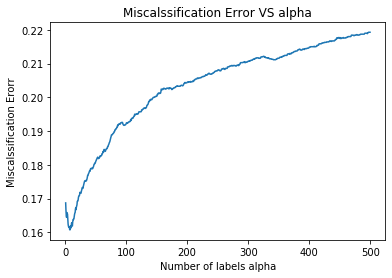

8.0

In [37]:
# To choose optimal_alpha using cross validation

optimal_alpha_bow = naive_bayes(X_train,y_train)
optimal_alpha_bow

In [38]:
# model
nb_optimal = MultinomialNB(alpha = optimal_alpha_bow)

# fit the model
nb_optimal.fit(X_train,y_train)

# predict the response
pred = nb_optimal.predict(x_test)

In [39]:
# get features names
bow_features = bow.get_feature_names()

In [40]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 11474)

In [41]:
#feature_count_ndarray of shape (n_classes, n_features)
#Number of samples encountered for each (class, feature) during fitting. 
#This value is weighted by the sample weight when provided

In [42]:
#class_count_ndarray of shape (n_classes,)
#Number of samples encountered for each class during fitting. 
#This value is weighted by the sample weight when provided.

In [43]:
# Number of samples encountered for each class during fitting
nb_optimal.class_count_

array([3488., 3512.])

In [44]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-10.29627261, -10.17848957, -10.29627261, ..., -10.17848957,
        -10.29627261, -10.17848957],
       [-10.11334321, -10.23112625, -10.11334321, ...,  -9.67151046,
        -10.11334321, -10.23112625]])

In [45]:
feature_prob = pd.DataFrame(log_prob,columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(11474, 2)

In [46]:
# show top 10 features from both class
# Feature Importance

print("Top 10 Negative Features: \n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features: \n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features: 
 tast      -4.759923
like      -4.815113
product   -4.907772
one       -5.242418
flavor    -5.292326
would     -5.376292
tri       -5.385458
use       -5.531964
get       -5.571100
good      -5.596929
Name: 0, dtype: float64


 Top 10 Positive Features: 
 like      -4.943491
tast      -5.016190
good      -5.144302
love      -5.180469
great     -5.185285
use       -5.207246
flavor    -5.229700
one       -5.314802
product   -5.408831
tri       -5.468952
Name: 1, dtype: float64


In [47]:
# accuracy on train data
train_acc_bow = nb_optimal.score(X_train,y_train)
print("Train Accuracy: ", train_acc_bow)

Train Accuracy:  0.8804285714285714


In [48]:
# Error on train data
train_err_bow = (1-train_acc_bow)*100
print("Train Error: %f%%" %train_err_bow)

Train Error: 11.957143%


In [49]:
# evaluate accuracy on test data
acc_bow = accuracy_score(y_test,pred)*100
print("Accuracy on for alpha = %d is %f%%" %(optimal_alpha_bow, acc_bow))

Accuracy on for alpha = 8 is 83.333333%


In [50]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred)
cm

array([[1276,  236],
       [ 264, 1224]], dtype=int64)

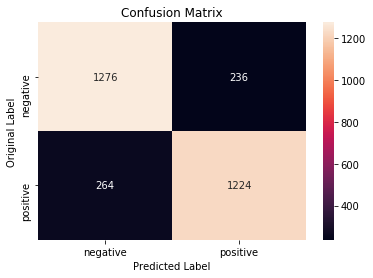

In [51]:
# plotting confusion matrix
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Original Label")
plt.show()

#### Observations:-

Out of 30k points 25638 points are correctly classified and test accuracy of our model is 85.46% when alpha is 15.5
So we can ay that generalization error is low so model works fine

In [52]:
# classification report 
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.83      0.84      0.84      1512
    positive       0.84      0.82      0.83      1488

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



## TF-IDF

In [53]:
X = final_10k["CleanText"]

In [54]:
y = final_10k["Score"]

In [55]:
# splitting the data 
from sklearn.model_selection import train_test_split
X_train,x_test,y_train,y_test = train_test_split(X, y, test_size = 0.3)
print(X_train.shape,x_test.shape,y_train.shape,y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range = (1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<7000x187832 sparse matrix of type '<class 'numpy.float64'>'
	with 494763 stored elements in Compressed Sparse Row format>

In [57]:
x_test = tf_idf_vect.transform(x_test)
x_test.shape

(3000, 187832)


 The optimal value of alpha is 1 


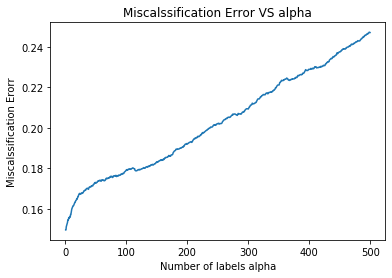

1.0

In [58]:
# choose optimal alpha
optimal_alpha_tfidf = naive_bayes(X_train,y_train)
optimal_alpha_tfidf

In [59]:
nb_optimal = MultinomialNB(alpha = optimal_alpha_tfidf)

# fit the model
nb_optimal.fit(X_train,y_train)

# predict the response
pred = nb_optimal.predict(x_test)

In [60]:
# To get all the features name

tfidf_features = tf_idf_vect.get_feature_names()

In [61]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 187832)

In [62]:
# Number of samples encountered for each class during fitting

nb_optimal.class_count_

array([3492., 3508.])

In [63]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-12.27386314, -12.27386314, -12.19249112, ..., -12.12571159,
        -12.27386314, -12.27386314],
       [-12.15778747, -12.15778747, -12.2681446 , ..., -12.2681446 ,
        -12.21757073, -12.21757073]])

In [64]:
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(187832, 2)

In [65]:
# Show top 10 feature from both class
print("Top 10 negative features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 positive features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 negative features:-
 tast      -8.034571
product   -8.123246
like      -8.137922
flavor    -8.466210
coffe     -8.479048
one       -8.479717
would     -8.518568
tri       -8.584022
buy       -8.633414
order     -8.667356
Name: 0, dtype: float64


 Top 10 positive features:-
 great     -8.117130
love      -8.168056
tea       -8.260408
good      -8.262052
tast      -8.306108
like      -8.325061
flavor    -8.349192
coffe     -8.381839
use       -8.395026
product   -8.536679
Name: 1, dtype: float64


In [66]:
# Train Accuracy
train_acc_tfidf = nb_optimal.score(X_train,y_train)
print("Train Acccuracy: ", train_acc_tfidf)

Train Acccuracy:  0.9905714285714285


In [68]:
# Error on train data
train_err_tfidf = (1 - train_acc_tfidf)*100
print("Train Error %f%%" %(train_err_tfidf))

Train Error 0.942857%


In [69]:
# evaluate accuracy
acc_tfidf = accuracy_score(y_test,pred)*100
print("\nThe accuracy for alpha = %d is %f%%" %(optimal_alpha_tfidf, acc_tfidf))


The accuracy for alpha = 1 is 86.700000%


In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred)
cm

array([[1316,  192],
       [ 207, 1285]], dtype=int64)

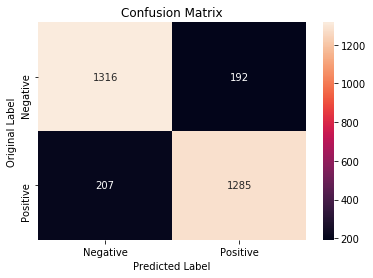

In [71]:
import seaborn as sns
class_label = ["Negative","Positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Original Label")
plt.show()

In [72]:
# classification report 
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.86      0.87      0.87      1508
    positive       0.87      0.86      0.87      1492

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



#### Observations:
1: optimal alpha for tfidf is 1.0

2: Accuracy of tfidf model is quite better than bow model.

3: In tfidf model train error and test erorr are both very small

4: So this model works fine with unseen data and have better or high accuracy than bow model.

#### Conclusions:
1: As we know when a model performs good on training data but poor performence on unseen data(test data)i.e. its dependent on training data only, tends to overfits and when a model perform poor performence on training data and good performence on test data i.e. it fails to learn relationship in training data tends to underfit. We need to balance between both i.e. reduce training error and balance error between both training and testing which is balanced in this case.

2: Another concept bias vs variance is also related with underfitting and overfitting. when a model has high bias and low variance tend to underfitting and its reverse- high variance and low bias called overfitting and we balanced using cross-validataion. As it is shown in below table where both models have low trainig error and test error.
overall, both of the models are performing well on unseen data.

3: We are not applying Naive Bayes to W2V representation as it sometimes give -ve values(i.e. if two word have 0cosine similarity the word is completely orthogonal i.e. they are not related to each other at all where 1 represents a perfect relationship between between word vectors. -ve relation means they have perfect opposite relationship between words). Naive Bayes assume that there is no relationship between any features . But we know that our features are dependent and there is relationship between features. So applying naive bayes doesnot make any sense.

In [73]:
# model performence table
models = pd.DataFrame({'Model': ['Naive Bayes with Bow', "Naive Bayes with TFIDF"], 
                       'Hyper Parameter(alpha)': [optimal_alpha_bow, optimal_alpha_tfidf], 
                       'Train Error': [train_err_bow, train_err_tfidf], 
                       'Test Error': [100-acc_bow, 100-acc_tfidf], 
                       'Accuracy': [acc_bow, acc_tfidf]}, 
                      columns = ["Model", "Hyper Parameter(alpha)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)


,Model,Hyper Parameter(alpha),Train Error,Test Error,Accuracy
1,Naive Bayes with TFIDF,1.0,0.942857,13.300000,86.700000
0,Naive Bayes with Bow,8.0,11.957143,16.666667,83.333333
